# [[공빅데] 감성분석(영어)-영화 리뷰(tf-idf, word2vec, random forest) 성능평가](https://cafe.naver.com/21pbds)

영어 감성분석을 여러 방법을 사용해 결과를 확인해본다.  
영화 리뷰와 관련되어 그 리뷰가 긍정인지 부정인지 두 가지로 나누어 잘 예측하는지 확인한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('pydata/labeledTrainData.tsv', 
                         header=0,
                         delimiter='\t', 
                         quoting=3 # 인용구(따옴표)를 무시
                        )
train_data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


데이터를 불러오면 긍정(1) 또는 부정(0)값, 리뷰 3개의 열이 있음을 확인할 수 있다.  
전체 데이터의 갯수를 확인하면

In [2]:
# 학습 데이터 갯수 확인
print('전체 학습 데이터의 개수: {}'.format(len(train_data)))

전체 학습 데이터의 개수: 25000


리뷰의 전체적인 정보를 알아본다.

In [3]:
# 리뷰 길이 확인
train_length = train_data['review'].apply(len)
train_length.head()

0    2304
1     948
2    2451
3    2247
4    2233
Name: review, dtype: int64

In [4]:
# 리뷰의 전체적인 정보 파악
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균값: {}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {}'.format(np.std(train_length)))
print('리뷰 길이 중앙값: {}'.format(np.median(train_length)))

# 사분위는 0~100 스케일
print('리뷰 길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰 길이 제3사분위: {}'.format(np.percentile(train_length, 75)))     

리뷰 길이 최댓값: 13710
리뷰 길이 최솟값: 54
리뷰 길이 평균값: 1329.71056
리뷰 길이 표준편차: 1005.2191407969154
리뷰 길이 중앙값: 983.0
리뷰 길이 제1사분위: 705.0
리뷰 길이 제3사분위: 1619.0


이렇게 리뷰에 대한 간단한 통계 정보를 확인할 수 있다.  
아래 방법으로 train_length를 데이터프레임으로 변환하고 describe 함수를 사용하여 빨리 확인할 수 있다.

In [5]:
pd.DataFrame(train_length).describe()

,review
count,25000.000000
mean,1329.710560
std,1005.239246
min,54.000000
25%,705.000000
50%,983.000000
75%,1619.000000
max,13710.000000


이번에는 긍저으, 부정 리뷰의 갯수를 countplot으로 시각화하여 확인한다.

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


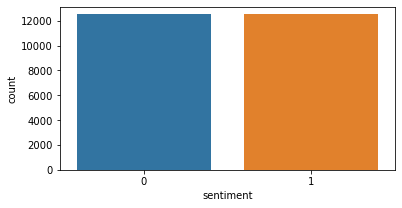

In [8]:
# seaborn으로 시각화
fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
sns.countplot(train_data['sentiment'])

plt.show()

긍/부정 리뷰 개수가 비슷함을 알 수 있다.

이번에는 한 리뷰 당 단어가 얼만큼 들어가 있는지 시각화 한다.

<ipython-input-9-3f89a10ce6df>:7: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


Text(0, 0.5, 'Number of reviews')

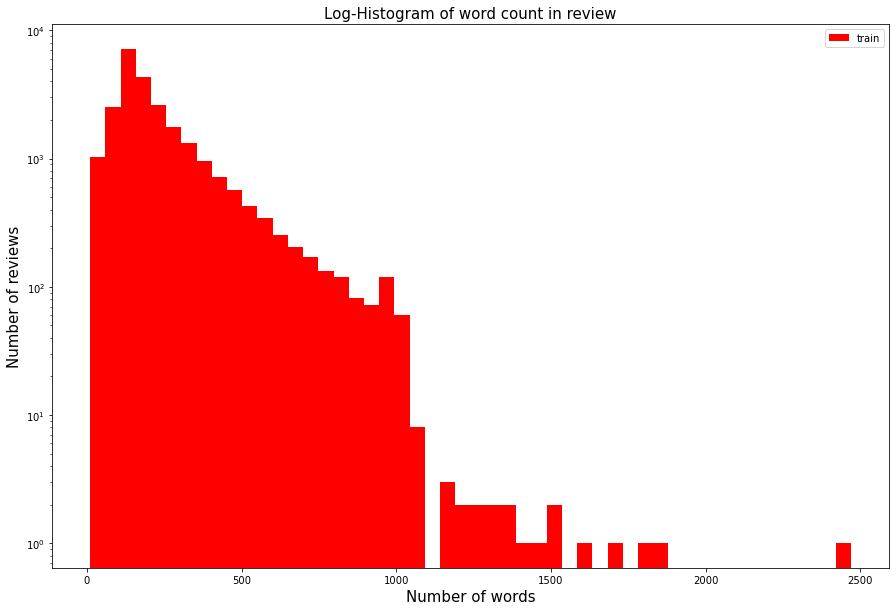

In [9]:
train_word_counts = train_data['review'].apply(lambda x: len(x.split(' ')))

# 리뷰의 단어 개수
plt.figure(figsize = (15, 10))
plt.hist(train_word_counts, bins = 50, facecolor = 'r', label='train')
plt.title('Log-Histogram of word count in review', fontsize = 15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of reviews', fontsize = 15)

또한 단어의 전체적인 통계를 내면 다음과 같다.

In [16]:
##통계값 확인
print('리뷰 단어 개수 최댓값: {}'.format(np.max(train_word_counts)))
print('리뷰 단어 개수 최솟값: {}'.format(np.min(train_word_counts)))
print('리뷰 단어 개수 평균값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간값: {}'.format(np.median(train_word_counts)))

print('리뷰 단어 개수 제1사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제3사분위: {}'.format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 최댓값: 2470
리뷰 단어 개수 최솟값: 10
리뷰 단어 개수 평균값: 233.79
리뷰 단어 개수 표준편차: 173.74
리뷰 단어 개수 중간값: 174.0
리뷰 단어 개수 제1사분위: 127.0
리뷰 단어 개수 제3사분위: 284.0


대부분의 리뷰는 200개 정도의 단어를 갖고 있다.  
이제 데이터 분석을 마치고 리뷰데이터 전처리를 진행한다.